## Community Detection with Network Embedding

This notebook aims at detecting communities of a network by 
1. applying network embedding on network to get vectorized representation of a graph,
2. apply clustering algorithm on these embedding to find communities,
3. and then applying dimensionality reduction tool, UMAP to visualize the cluster.

### Data
1. [Les Misérables Network](http://konect.uni-koblenz.de/test/networks/moreno_lesmis).


### Reference
1. node2vec: Scalable Feature Learning for Networks, Aditya Grover, Jure Leskovec. 2016. [Paper](https://arxiv.org/pdf/1607.00653.pdf), [Code](https://github.com/aditya-grover/node2vec).
2. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, Leland McInnes, John Healy, James Melville, 2018. [Paper](https://arxiv.org/pdf/1802.03426.pdf). [Code](https://github.com/lmcinnes/umap). 
3. UMAP Documentation, Leland McInnes. [Doc](https://media.readthedocs.org/pdf/umap-learn/latest/umap-learn.pdf).

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
import umap

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 8)
sns.set_palette(palette)

In [2]:
import random
random.seed(246)        # or any integer
import numpy
numpy.random.seed(4812)

In [3]:
def get_sub_plot(width = 10, height = 6, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

### Exploratory Data Analysis on the Network Data

In [4]:
# Inspect the graph
!ls graph/*

graph/karate.edgelist         graph/les_miserables.edgelist


In [5]:
# Use les_miserables as graph data
graph_file = 'graph/les_miserables.edgelist'

In [6]:
with open(graph_file) as f:
    print(f.read())

1 2 1
2 3 8
2 4 10
2 5 1
2 6 1
2 7 1
2 8 1
2 9 2
2 10 1
2 11 5
3 4 6
3 11 3
4 11 3
11 12 1
11 13 1
11 14 1
11 15 1
11 16 1
11 24 9
11 25 7
11 26 12
11 27 31
11 28 17
11 29 8
11 30 2
11 32 3
11 33 1
11 34 2
11 35 3
11 36 3
11 37 2
11 38 2
11 39 2
11 44 3
11 45 1
11 49 1
11 50 2
11 52 2
11 56 19
11 59 4
11 65 1
11 69 1
11 70 1
11 71 1
11 72 1
11 73 1
13 24 2
17 18 4
17 19 4
17 20 4
17 21 3
17 22 3
17 23 3
17 24 3
18 19 4
18 20 4
18 21 3
18 22 3
18 23 3
18 24 3
18 27 1
18 56 1
19 20 4
19 21 3
19 22 3
19 23 3
19 24 3
20 21 4
20 22 3
20 23 3
20 24 3
21 22 5
21 23 4
21 24 4
22 23 4
22 24 4
23 24 4
24 25 2
24 26 1
24 28 5
24 30 1
24 31 1
24 32 2
25 26 13
25 27 4
25 28 1
25 42 2
25 43 1
25 51 1
25 69 1
25 70 1
25 71 1
26 27 1
26 28 5
26 40 1
26 41 1
26 42 3
26 43 2
26 49 1
26 56 2
26 69 5
26 70 6
26 71 4
26 72 1
26 76 3
27 28 1
27 44 1
27 50 3
27 52 2
27 55 1
27 56 21
27 73 2
28 29 1
28 30 1
28 32 1
28 34 1
28 44 1
28 49 1
28 59 6
28 69 1
28 70 2
28 71 1
28 72 1
28 73 1
29 45 3
29 46 2
30 35 2

In [7]:
# load data and report basic info
G = nx.read_edgelist(graph_file, nodetype = int, data=(('weight', float),))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974


### Generate Network Embedding with Node2vec

In [8]:
graph_file

'graph/les_miserables.edgelist'

In [9]:
# Call node2vec package to generate embedding
!python node2vec/src/main.py --input graph/les_miserables.edgelist --output emb/les_miserables.emb --dimensions 16 --p 1 --q 0.5 --walk-length 7 --iter 200 --weighted

[Starting Random Walks]
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10

[Starting Learning Embeddings]
Saved Embedding at emb/les_miserables.emb



In [10]:
emb_file = 'emb/les_miserables.emb'

In [11]:
# inspect the embedding
with open(emb_file) as f:
    print(f.read())

77 16
11 -0.14713545 -0.4152757 0.2541586 0.09384078 0.36976495 -0.62578326 -0.34838966 0.09484124 -0.06368401 0.50097686 0.19149084 -0.15201715 0.31588164 -0.5661371 0.7800747 0.12382626
56 -0.08032678 -0.5326751 -0.17905007 0.5656507 -0.09188692 -0.44283125 -0.46951956 -0.5100342 -0.109718494 -0.07384115 0.5101491 -0.5920928 -0.10067114 -0.36490563 0.604105 -0.065403946
2 0.1686179 0.3361535 0.6150564 0.15411465 0.7234131 -1.7336539 -0.18616495 0.5433392 -0.7178883 -0.20639339 0.77580774 0.49657398 0.16528834 -0.96096057 0.83156747 1.1247679
26 -0.5037567 -0.7220984 -0.070214674 0.29936954 0.09826184 -0.50322044 -0.11669317 -0.2298845 0.3520069 0.53827065 -0.17493305 0.4219806 -0.38089445 -1.191437 0.4959252 -0.037490353
27 -0.051684003 -0.5788386 -0.13332932 0.27650058 0.06597232 -0.7434236 -0.56701404 -0.020899238 -0.19413449 0.068201736 0.20596732 -0.61982775 0.09884082 -0.38959762 0.54477006 0.10259269
24 -0.6417147 -0.6967755 0.69888306 0.05831445 0.89692384 -0.14568198 -0.65336

### Applying Clustering Algorithms for Community Detection

In [12]:
# load the embedding in numpy array
embs = np.loadtxt(emb_file, delimiter = " ", skiprows = 1)

In [13]:
# skip the first column since it's the node id
node_ids = [int(emb[0]) for emb in embs]
print(node_ids)

[11, 56, 2, 26, 27, 24, 59, 63, 28, 49, 65, 25, 60, 4, 3, 50, 62, 52, 70, 66, 23, 20, 69, 21, 64, 42, 22, 29, 17, 36, 71, 19, 18, 35, 76, 58, 39, 37, 38, 30, 61, 74, 32, 75, 67, 72, 47, 77, 9, 34, 45, 10, 6, 13, 44, 40, 43, 68, 31, 5, 55, 1, 51, 54, 46, 48, 33, 8, 73, 53, 7, 16, 41, 57, 14, 12, 15]


In [14]:
embs = np.array([emb[1:] for emb in embs])
print(embs)

[[-0.14713545 -0.4152757   0.2541586  ... -0.5661371   0.7800747
   0.12382626]
 [-0.08032678 -0.5326751  -0.17905007 ... -0.36490563  0.604105
  -0.06540395]
 [ 0.1686179   0.3361535   0.6150564  ... -0.96096057  0.83156747
   1.1247679 ]
 ...
 [ 0.9960689  -0.10749312  0.43532264 ... -0.697105   -0.67434835
   0.6854056 ]
 [ 1.3184508  -0.958173   -0.32196468 ... -1.0428288   0.14359926
   0.30849504]
 [ 0.35372496  0.1825821   0.20913813 ... -0.7401733  -0.08180263
   1.756047  ]]


In [15]:
kmeans = KMeans(n_clusters = 6, n_init = 50, max_iter = 500, verbose = 0, random_state = 42).fit(embs)
print(kmeans.labels_)

[0 5 3 2 5 1 4 4 2 4 4 2 4 3 3 5 4 5 2 4 1 1 2 1 4 2 1 0 1 0 2 1 1 0 2 4 0
 0 0 0 4 4 1 4 4 2 4 4 3 0 0 3 3 1 2 5 2 4 1 3 5 3 5 5 0 4 0 3 0 5 3 0 2 5
 1 0 3]


In [16]:
df_emb_clulstered = pd.DataFrame({'node_id' : node_ids, 'emb': list(embs), 'cluster' : kmeans.labels_})
df_emb_clulstered = df_emb_clulstered[['node_id', 'emb', 'cluster']]

In [17]:
df_emb_clulstered.sort_values(by = ['node_id']).head(20)

,node_id,emb,cluster
61,1,"[0.12744801, 0.66536033, 0.89277256, 0.5959949...",3
2,2,"[0.1686179, 0.3361535, 0.6150564, 0.15411465, ...",3
14,3,"[0.6724742, 0.3458571, 0.96298355, -0.05631352...",3
13,4,"[0.24044384, 0.6056416, 0.5882285, 0.3585672, ...",3
59,5,"[0.09832199, 0.41133296, 0.64929324, 0.8660718...",3
52,6,"[0.5082254, 0.9080713, 1.2417853, 0.78369534, ...",3
70,7,"[0.26775622, 0.99434793, 0.30982, 0.7010023, 0...",3
67,8,"[0.33087754, -0.25167215, 0.549198, 1.517006, ...",3
48,9,"[0.28472054, 0.7776767, 0.8407406, 0.3936124, ...",3
51,10,"[-0.40763026, 0.6037169, 1.4355967, 0.6904538,...",3


### Visualize Embedding with Dimensionality Reduction

In [18]:
# Apply UMAP to reduce the embedding into two-dim format.
reducer = umap.UMAP(n_components = 2,
                    min_dist = 0.99,
                    spread = 0.99,
                    metric = 'euclidean',
                    local_connectivity = 5,
                    n_neighbors = 10,
                    random_state = 42,
                    n_epochs = 1000,
                    verbose = True)

reduced_embs = reducer.fit_transform(embs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=5, metric='euclidean',
   metric_kwds=None, min_dist=0.99, n_components=2, n_epochs=1000,
   n_neighbors=10, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=0.99,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs


Now the data is being reduced into two-dim format.

Let's plot the reduced data:

In [19]:
# get dataframe with the reduced embedding
df_emb_clulstered['reduced_x'] = reduced_embs[:, 0]
df_emb_clulstered['reduced_y'] = reduced_embs[:, 1]
df_emb_clulstered.head()

,node_id,emb,cluster,reduced_x,reduced_y
0,11,"[-0.14713545, -0.4152757, 0.2541586, 0.0938407...",0,27.985731,7.453204
1,56,"[-0.08032678, -0.5326751, -0.17905007, 0.56565...",5,28.143259,9.059764
2,2,"[0.1686179, 0.3361535, 0.6150564, 0.15411465, ...",3,23.768627,3.905028
3,26,"[-0.5037567, -0.7220984, -0.070214674, 0.29936...",2,29.880026,7.377708
4,27,"[-0.051684003, -0.5788386, -0.13332932, 0.2765...",5,27.546450,8.337140


In [20]:
node2posMap = {}

for index, row in df_emb_clulstered.iterrows():
    node2posMap[row['node_id']] = [row['reduced_x'], row['reduced_y']]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


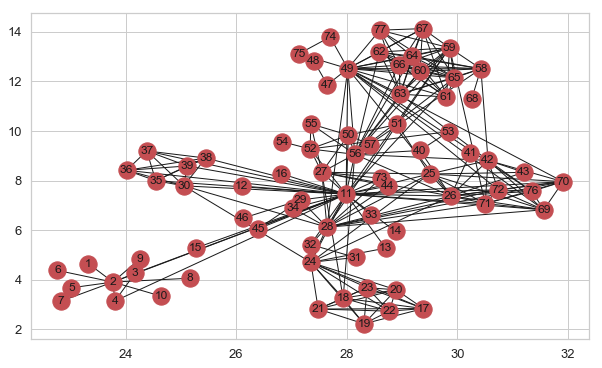

In [21]:
ax = get_sub_plot()
nx.draw_networkx(G, pos = node2posMap, ax = ax)

In [22]:
node2clusterMap = {}

for index, row in df_emb_clulstered.iterrows():
    node2clusterMap[row['node_id']] = row['cluster']

clusters = [node2clusterMap[node] for node in G.nodes()]

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


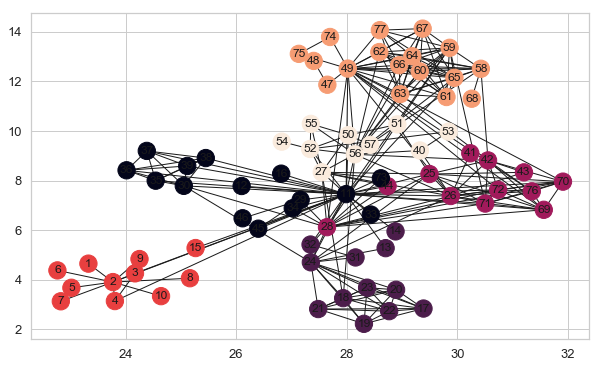

In [23]:
ax = get_sub_plot()
nx.draw_networkx(G, pos = node2posMap, node_color = clusters, ax = ax)